# Newbie Note

You can just scroll through this document and read it.
If you want to change some of the source code and try it yourself, simply edit the code and press the play button to the left of the code.
If you get errors, be sure you have first run all the previous code in the document. The easiest way to do that is pick "Run All" from the "Runtime" menu.

# Net Present Value
This document shows how to compute the net present value (NPV) for a product.

Let's get things started by importing a few things we need.

In [1]:
import numpy as np # linear algebra library
import matplotlib.pyplot as plt # plotting library

Now let's define a present value function and a future value function.

In [2]:
def pv(future_value, rate, periods):
    return future_value / (1 + rate) ** periods

def fv(present_value, rate, periods):
    return present_value * (1 + rate) ** periods

For example, what is the future value of $100 at a rate of 3% per year after 5.4 years?

Feel free to change the values and press the run button to the left of the code. Remember, if you see an error, make sure to pick "Run All" from the "Runtime" menu the first time.

In [3]:
fv(100, 0.03, 5.4)

117.30621265790838

# Company Constants
Now let's define some global constants for our company

In [4]:
# what we would expect to earn on an investment in a financial market with a similar risk
market_return = 0.03

# how much it costs per person to run a product development team (in present dollars)
development_fte_cost_pv = 50000

# how much the cost of development increases each year
development_cost_trend = 0.03

# how much the cost of a product increases each year
unit_cost_trend = 0.03

# how much the selling price of a product increases each year
unit_price_trend = 0.03

# the percentage of the selling price that is allocated to cover selling, general, and administrative expenses
sga_percentage = 0.30

So let's see how much it costs per person in a development team in three years from now.

In [5]:
fv(development_fte_cost_pv, development_cost_trend, 3)

54636.35

# Product Variables
Now let's define some more variables that describe our product.

In [6]:
# the number of people (full time equivalents) on the development team
development_ftes = 5

# the number of years remaining to develop the product
remaining_development_years = 4

# the number of remaining years after development that the product will be sold
remaining_delay_years = 1

# the number of people that need to keep working on the product after development
maintenance_ftes = 0.5

# the cost to manufacture one unit of the product (in present dollars)
unit_cost_pv = 10000

# the selling price of the product (in present dollars)
unit_price_pv = 20000

# the number of units that are expected to be sold per year
yearly_unit_sales = 100

# the number of years that the product is expected to be sold
remaining_years_of_sales = 10

# The NPV Calculation
Now let's write a (big) function that calculates the net present value of the product given the variables above.

We first run through the remaining development years and remove those costs from our NPV

We then run through the remaining delay years, just removing maintenance costs from our NPV

We then run through all the remaining years of product sales, adding in sales and removing costs

In [7]:
def calculate_npv(remaining_development_years, development_ftes, maintenance_ftes, remaining_delay_years, unit_cost_pv, unit_price_pv, yearly_unit_sales, remaining_years_of_sales):

    # this is what we will calculate and return 
    npv = 0

    # starting at year zero (today)
    year = 0

    # let's compute the remaining product development costs, one year at a time
    for _ in range(remaining_development_years):

        # compute the future value of the cost of development for this year
        development_cost_fte_fv = fv(development_fte_cost_pv, development_cost_trend, year)

        # compute the future value of this year (as a negative)
        fv_year = -development_cost_fte_fv * development_ftes

        # add the (negative) cost of development to the npv
        npv += pv(fv_year, market_return, year)

        # move to the next year
        year += 1

    # let's compute the cost of delay
    for _ in range(remaining_delay_years):

        # compute the future value of the cost of development for this year
        development_cost_fte_fv = fv(development_fte_cost_pv, development_cost_trend, year)

        # compute the future value of this year (as a negative)
        fv_year = -development_cost_fte_fv * maintenance_ftes

        # add the (negative) cost of development to the npv
        npv += pv(fv_year, market_return, year)

        # move to the next year
        year += 1


    # let's compute and add in the sales
    for j in range(remaining_years_of_sales):
        
        # compute the future value of the selling price, unit cost, and cost of development for this year
        list_price_fv = fv(unit_price_pv, unit_price_trend, year)
        unit_cost_fv = fv(unit_cost_pv, unit_cost_trend, year)
        development_cost_fte_fv = fv(development_fte_cost_pv, development_cost_trend, year)
        
        # compute the selling, general, and administrative expenses per unit
        sga_fv = list_price_fv * sga_percentage

        # compute the future value of this year
        fv_year = 0
        fv_year -= development_cost_fte_fv * maintenance_ftes
        fv_year += yearly_unit_sales * list_price_fv
        fv_year -= yearly_unit_sales * unit_cost_fv
        fv_year -= yearly_unit_sales * sga_fv

        # add the net to the npv
        npv += pv(fv_year, market_return, year)

        # move to the next year
        year += 1

    return npv


Let's compute the NPV for our variables.

In [8]:
calculate_npv(remaining_development_years, development_ftes, maintenance_ftes, remaining_delay_years, unit_cost_pv, unit_price_pv, yearly_unit_sales, remaining_years_of_sales)

2724999.9999999995

# Ranges
Our product parameters always have some uncertainty. For example, suppose we wanted to specifiy our yearly unit sales not simply as 100, but rather as a number that could be anywhere from 80 to 120, but most likely around 100. We can define a triangluar distribution of numbers, generate 1000 samples of this distribution, and plot what it looks like. Feel free to change the variables and run this again.

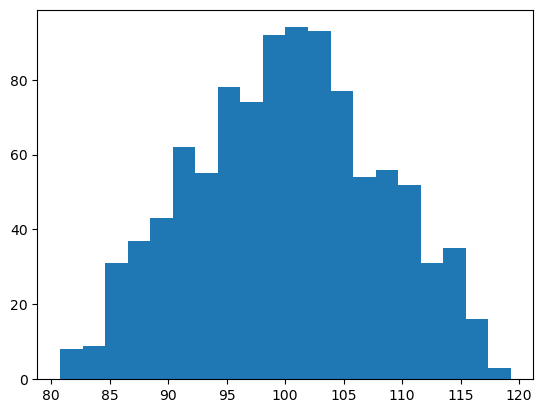

In [9]:
sales = np.random.triangular(80, 100, 120, size=1000)
plt.hist(sales, bins=20)
plt.show()

# Product Variable Ranges
So let's redefine all our product parameters as distributions.

Then, we will generate a single random value for each product parameter and compute one NPV.

Each time we call this function, it will return a different NPV based upon the random product parameters generated.

In [10]:
def simulate_npv():

    # the number of people (full time equivalents) on the development team
    development_ftes = np.random.triangular(4, 5, 6)

    # the number of years remaining to develop the product
    remaining_development_years = round(np.random.triangular(3, 4, 5))

    # the number of remaining years after development that the product will be sold
    remaining_delay_years = round(np.random.triangular(0, 1, 2))

    # the number of people that need to keep working on the product after development
    maintenance_ftes = np.random.triangular(0, 0.5, 1)

    # the cost to manufacture one unit of the product (in present dollars)
    unit_cost_pv = np.random.triangular(8000, 10000, 12000)

    # the selling price of the product (in present dollars)
    unit_price_pv = np.random.triangular(16000, 20000, 24000)

    # the number of units that are expected to be sold per year
    yearly_unit_sales = np.random.triangular(80, 100, 120)

    # the number of years that the product is expected to be sold
    remaining_years_of_sales = round(np.random.triangular(8, 10, 12))

    npv = calculate_npv(remaining_development_years, development_ftes, maintenance_ftes, remaining_delay_years, unit_cost_pv, unit_price_pv, yearly_unit_sales, remaining_years_of_sales)
    
    return npv

Let's try it a few times. Feel free to press the run botton on the left to generate another three runs.

In [11]:
print(simulate_npv())
print(simulate_npv())
print(simulate_npv())

1777669.5034936736
4409714.650969434
1156328.7364936057


# Monte Carlo Simulation
It is hard to make sense of running the simulation three times. But we can run it 10000 times and plot the result like this. Each time you run this, the plot looks slighty different, but the general shape and midpoint are the same. Feel free to try running 80000 simulations to see if that helps stabilize the results.

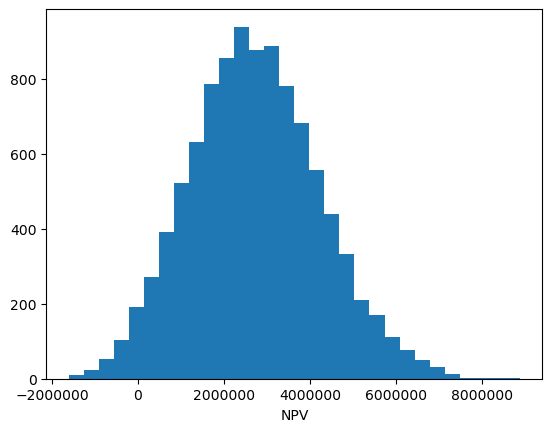

In [12]:
npvs = []

for i in range(10000):
    npv = simulate_npv()
    npvs.append(npv)

plt.hist(npvs, bins=30)
plt.xlabel('NPV')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

# Interrelated Product Variables
It may be more accurate to define the range of unit price as a function of unit cost.

For example, let's define price to be 2 times the cost, but allow  it to range from 1.9 to 2.1 times the cost. We can do it this way.

In [13]:
np.random.triangular(unit_cost_pv * 1.9, unit_cost_pv * 2, unit_cost_pv * 2.1)

20218.907867183487

It is a bit more complicated, but we can make yearly unit sales a function of unit price.

For example, let's define sales to be exactly 120 if the selling price is 16000 and exactly 80 if the price is 24000 and interpolate values inbetween.

In [14]:
price_range = np.array([16000, 24000])
sales_range = np.array([120, 80])
print(np.interp(16000, price_range, sales_range))
print(np.interp(24000, price_range, sales_range))
print(np.interp(20000, price_range, sales_range))

120.0
80.0
100.0


Let's make it a bit more complicated and have the interpolated sales vary by 10%

In [15]:
exact_sales = np.interp(20000, price_range, sales_range)
np.random.triangular(exact_sales * 0.9, exact_sales, exact_sales * 1.1)

95.58338369911537

Now putting it all together.

In [16]:
def simulate_npv_v2():

    # the number of people (full time equivalents) on the development team
    development_ftes = np.random.triangular(4, 5, 6)

    # the number of years remaining to develop the product
    remaining_development_years = round(np.random.triangular(3, 4, 5))

    # the number of remaining years after development that the product will be sold
    remaining_delay_years = round(np.random.triangular(0, 1, 2))

    # the number of people that need to keep working on the product after development
    maintenance_ftes = np.random.triangular(0, 0.5, 1)

    # the cost to manufacture one unit of the product (in present dollars)
    unit_cost_pv = np.random.triangular(8000, 10000, 12000)

    # the selling price of the product (in present dollars)
    unit_price_pv = np.random.triangular(unit_cost_pv * 1.9, unit_cost_pv * 2, unit_cost_pv * 2.1)

    # the number of units that are expected to be sold per year
    price_range = np.array([16000, 24000])
    sales_range = np.array([120, 80])
    exact_sales = np.interp(20000, price_range, sales_range)
    yearly_unit_sales = np.random.triangular(exact_sales * 0.9, exact_sales, exact_sales * 1.1)

    # the number of years that the product is expected to be sold
    remaining_years_of_sales = round(np.random.triangular(8, 10, 12))

    npv = calculate_npv(remaining_development_years, development_ftes, maintenance_ftes, remaining_delay_years, unit_cost_pv, unit_price_pv, yearly_unit_sales, remaining_years_of_sales)
    
    return npv

Let's run a Monte Carlo simulation with this new version. Compare this with the previous results and you can see the spreat of possibilities is now much less.

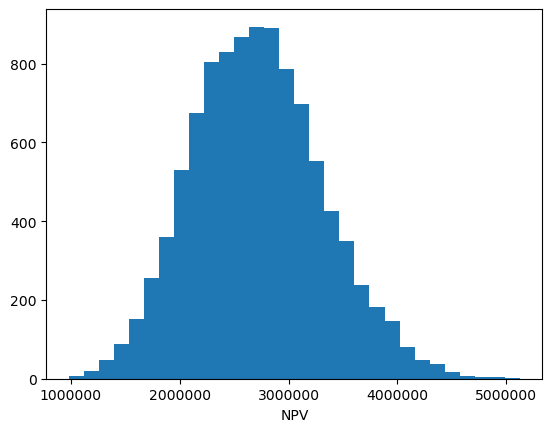

In [17]:
npvs = []

for i in range(10000):
    npv = simulate_npv_v2()
    npvs.append(npv)

plt.hist(npvs, bins=30)
plt.xlabel('NPV')
plt.ticklabel_format(style='plain', axis='x')
plt.show()